In [2]:
%run -i "loaddata.py"
plt.rcParams["font.size"] = 16
import scipy.stats as st
save = False

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


### The timeseries

In [4]:
all_keys = tuple(data_dict.keys())
keys = [all_keys[i] for i in range(len(all_keys)) if i%2==0]

x = np.array([data_dict[keys[i]][:,0] for i in range(len(keys))])
y = np.array([data_dict[keys[i]][:,1] for i in range(len(keys))])
features = data_dict[all_keys[1]]

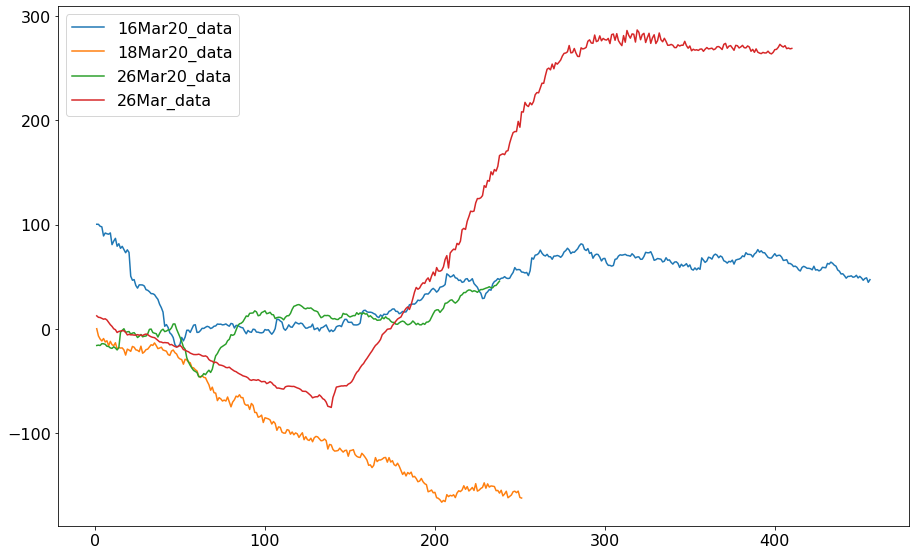

In [4]:
fig = plt.figure(figsize=(13,8))
for i in range(4):
    plt.plot(y[i], label=keys[i])
plt.legend()
plt.tight_layout()
plt.show()

if save:
    fig.savefig("figs/RVS.pdf")

### Stacked histograms of feature distributions

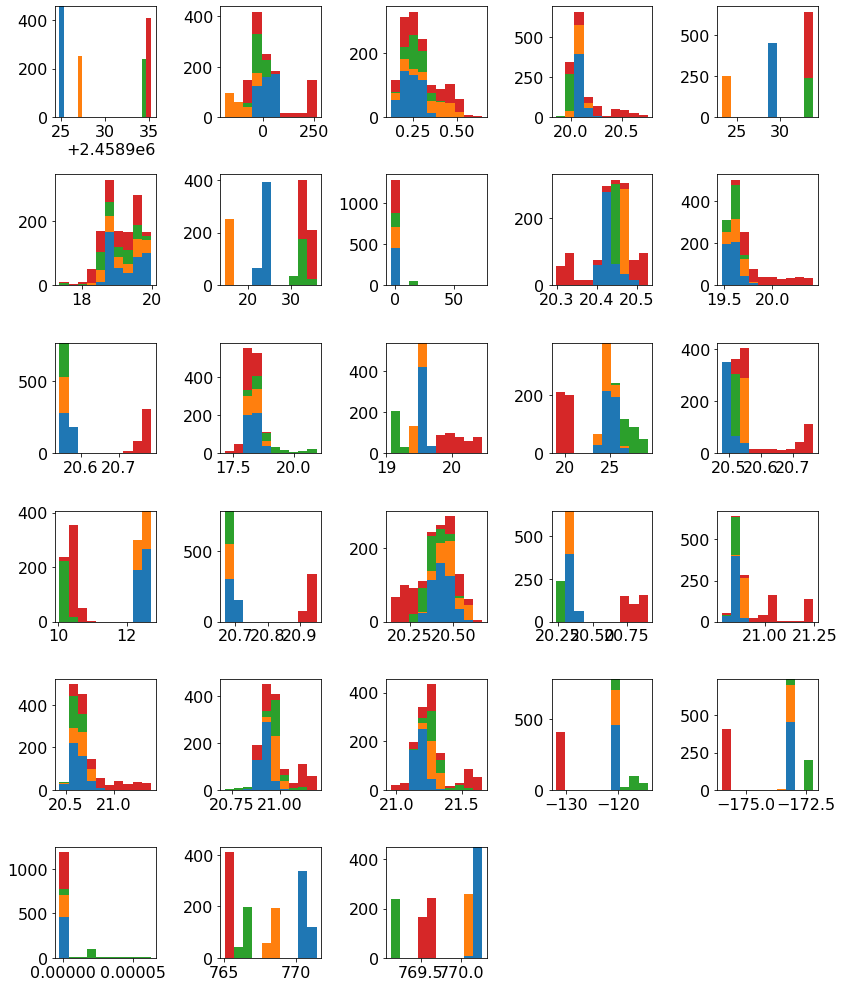

In [4]:
fig = plt.figure(figsize=(12,14))
for i in range( data_dict[keys[0]].shape[1] ):
    plt.subplot(6,5,i+1)
    # Mask to remove 0
    mask = [ data_dict[keys[0]][:,i] != 0., data_dict[keys[1]][:,i] != 0., 
            data_dict[keys[2]][:,i] != 0., data_dict[keys[3]][:,i] != 0. ]
    if i == 0:
        plt.hist([data_dict[keys[0]][mask[0],i], data_dict[keys[1]][mask[1],i], 
                  data_dict[keys[2]][mask[2],i], data_dict[keys[3]][mask[3],i]], 
                 histtype='barstacked', align='left', bins=20)
    else:
        plt.hist([data_dict[keys[0]][mask[0],i], data_dict[keys[1]][mask[1],i], 
                  data_dict[keys[2]][mask[2],i], data_dict[keys[3]][mask[3],i]], 
                 histtype='barstacked', align='left')
plt.tight_layout()
plt.show()

if save:
    fig.savefig("figs/features_hist.pdf")

### RVS correlations

In [ ]:
fig = plt.figure(figsize=(12,25))
for i in range(3,data_dict[keys[0]].shape[1]):
    plt.subplot(9,3,i-2)
    for key in keys:
        mask = (data_dict[key][:,i] != 0.) & (np.isnan(data_dict[key][:,i])!=True )
        plt.scatter(data_dict[key][mask,i], data_dict[key][mask,1], s=5, label=f"var: {np.var(data_dict[key][mask,i]):.2e}")
        ax = plt.gca()
        
        if i%3!=0:
            ax.axes.get_yaxis().set_visible(False)
    if i%3==0:
        plt.ylabel("RVS")
    plt.xlabel(features[i], fontsize=9)
        
    plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

if save:
    fig.savefig("figs/correlations.pdf")

### t-SNE

In [7]:
def remove_nan(X, y):
    remove = np.isnan(X)[:,0]
    remove1 = [i for i in range(len(remove)) if remove[i]==False]
    return X[remove1,:], y[remove1]

In [8]:
from sklearn.manifold import TSNE
# Collect all data in a single array
data = data_dict[keys[0]]
for i in range(1,4):
    data = np.append(data, data_dict[keys[i]],axis=0)
    
y_labels = data[:,1]
X = data[:,3:]

# Remove nan
X, y_labels = remove_nan(X, y_labels)

tsne = TSNE(n_components = 2, n_jobs=-1, verbose=0, random_state=42)
tsne_data = tsne.fit_transform(X)

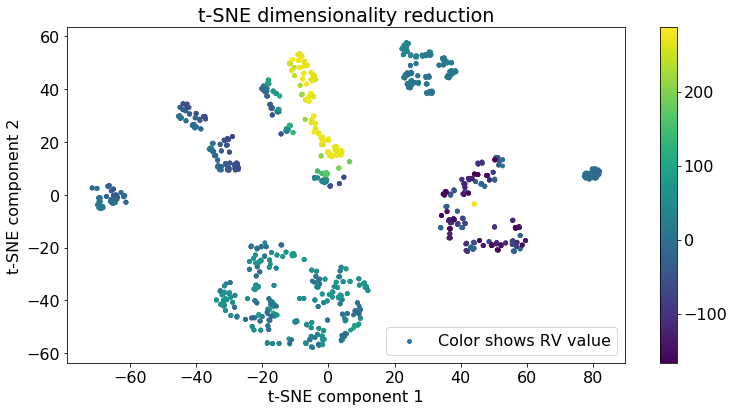

In [9]:
fig = plt.figure(figsize=(11,6))
plt.title("t-SNE dimensionality reduction")
plt.scatter(tsne_data[:,0], tsne_data[:,1], s=15, c = y_labels, label="Color shows RV value")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.colorbar()
plt.legend()
plt.tight_layout()
plt.show()

if save:
    fig.savefig("figs/t-SNE.pdf")